Lors du mois d'octobre 2016, j'ai participé à une compétition sur le site Kaggle.com dont le but était de classé une liste d'observations dans une des trois catégories suivantes: "Ghost", "Goblin" ou bien "Goul". Le but de la compétition était d'appliquer les algorithmes de partitionnement dans un contexte non-compétitif qui favorise l'échange entre les participants. J'ai eu beaucoup de plaisir à travailler avec ces données et ci-dessous, j'ai décris comment j'ai approché le problème.

Dans cette compétitions, nous avions à notre disposition deux jeu de données: une pour entrainer notre modèle et l'autre pour le tester. 

In [20]:
# Charger les packages à utiliser
library(data.table)
library(ggplot2)
library(ggthemes)
library(corrplot)


#Lire les données 
monstres <- fread("./Kaggle/train/train.csv",stringsAsFactors = T)
monstres_test <- fread("./Kaggle/test/test.csv",stringsAsFactors = T)
head(monstres)
#head(monstres_test)

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
1,0,0.354512184582154,0.35083902671065,0.465760891829121,0.78114166586219,clear,Ghoul
2,1,0.575559905025466,0.425868432210585,0.531401378709141,0.439898877037289,green,Goblin
3,2,0.467875498742323,0.354330420391775,0.811616089668924,0.791224973337769,black,Ghoul
4,4,0.776652460655474,0.508722549943229,0.636765579959788,0.884463692097697,black,Ghoul
5,5,0.56611660205779,0.875861795506256,0.41859367087488,0.636437818727937,green,Ghost
6,7,0.405679744891883,0.253277496666039,0.441419671072687,0.28032381992139,green,Goblin


De cet aperçu, nous voyons que les données de références sont groupées en sept colonnes: quatres colonne contenant des variables continue, deux colonnes contenant des variables cathégoriques, dont la variables "type" représentant les cibles de notre modèle et la première colonne contient l'indexe principal du tableau. Cette dernière pourra être ignoré lors de l'analyse. Finalement, nous remarquons que chaque ligne correspond à une seule observation et chaque colonne représente une seule variable, alors nous n'avons pas à modifier le tableau pour qu'il respecte les principes du "tidy data".

Pour explorer les données, j'ai créer un échantillon aléatoire contenant 70% des données que j'ai enregistré dans le data frame nommé "train". Ce dernier nous servira de référence lors de notre analyse, alors que le 30%  restant est réservé dans le data frame "cross_val" que nous utiliserons lors de la validation croisée

In [2]:
train.indice <- sample(1:nrow(monstres), round(nrow(monstres)*0.7))
train <- monstres[train.indice , ]
cross_val <- monstres[-train.indice , ]

Imprimons les statistiques descriptives principales de chacune des variables:

In [3]:
summary(monstres)
sum(is.na(monstres))

       id         bone_length      rotting_flesh      hair_length    
 Min.   :  0.0   Min.   :0.06103   Min.   :0.09569   Min.   :0.1346  
 1st Qu.:205.5   1st Qu.:0.34001   1st Qu.:0.41481   1st Qu.:0.4074  
 Median :458.0   Median :0.43489   Median :0.50155   Median :0.5386  
 Mean   :443.7   Mean   :0.43416   Mean   :0.50685   Mean   :0.5291  
 3rd Qu.:678.5   3rd Qu.:0.51722   3rd Qu.:0.60398   3rd Qu.:0.6472  
 Max.   :897.0   Max.   :0.81700   Max.   :0.93247   Max.   :1.0000  
    has_soul          color         type    
 Min.   :0.009402   black: 41   Ghost :117  
 1st Qu.:0.348002   blood: 12   Ghoul :129  
 Median :0.466372   blue : 19   Goblin:125  
 Mean   :0.471392   clear:120               
 3rd Qu.:0.600610   green: 42               
 Max.   :0.935721   white:137               

[1] 0

Bonne nouvelle! Il n'y a aucune donnée manquante dans le tableau, alors je vais pouvoir utiliser chaque observation sans avoir à estimer la valeur des données manquantes. Une autre catéristiques intéressente de ces données est que chaque variable continues à une valeur maximale et une valeur minimun approximativement égale à 1 et 0, respectivement. Cela nous assure qu'une variable n'aura pas d'influence indu sur les algorithmes que nous allons utiliser. Si cela n'aurait pas été le cas, il aurait été préférable de faire une normalisation des données. 

En regardant les statistiques descriptives de plus près, nous voyons que chaque variable continue est distribuée selon une distribution ayant une moyenne et une medianne qui sont à peu près égale et leurs premiers et leurs troisièmes quantille sont à distance sensiblement égales de la moyenne ce qui peut indiquer que ces variables sont distribuées selon une loi normale. Affichons les graphiques des distributions de ces variables continues et appliquons le test de Normalité de Shapiro pour vérifier cette hypothèse.

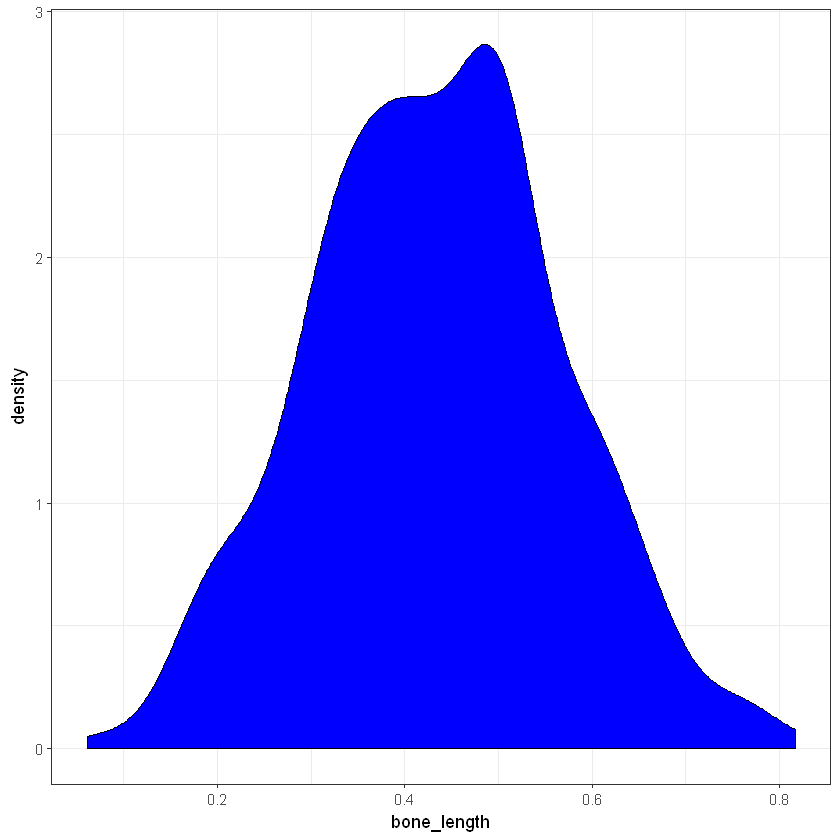

In [4]:
ggplot(monstres,aes(bone_length))+geom_density(fill="blue")+ theme_bw()

In [8]:
shapiro.test(monstres$bone_length)


	Shapiro-Wilk normality test

data:  monstres$bone_length
W = 0.99689, p-value = 0.7025


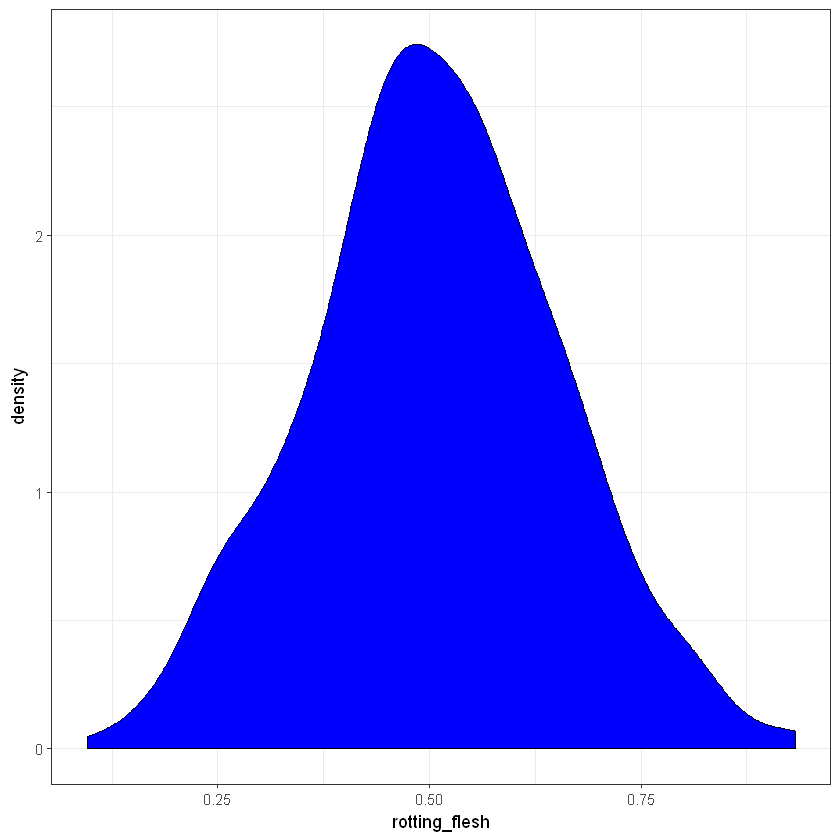

In [5]:
ggplot(monstres,aes(rotting_flesh))+geom_density(fill="blue")+ theme_bw()

In [11]:
shapiro.test(monstres$rotting_flesh)


	Shapiro-Wilk normality test

data:  monstres$rotting_flesh
W = 0.99781, p-value = 0.9132


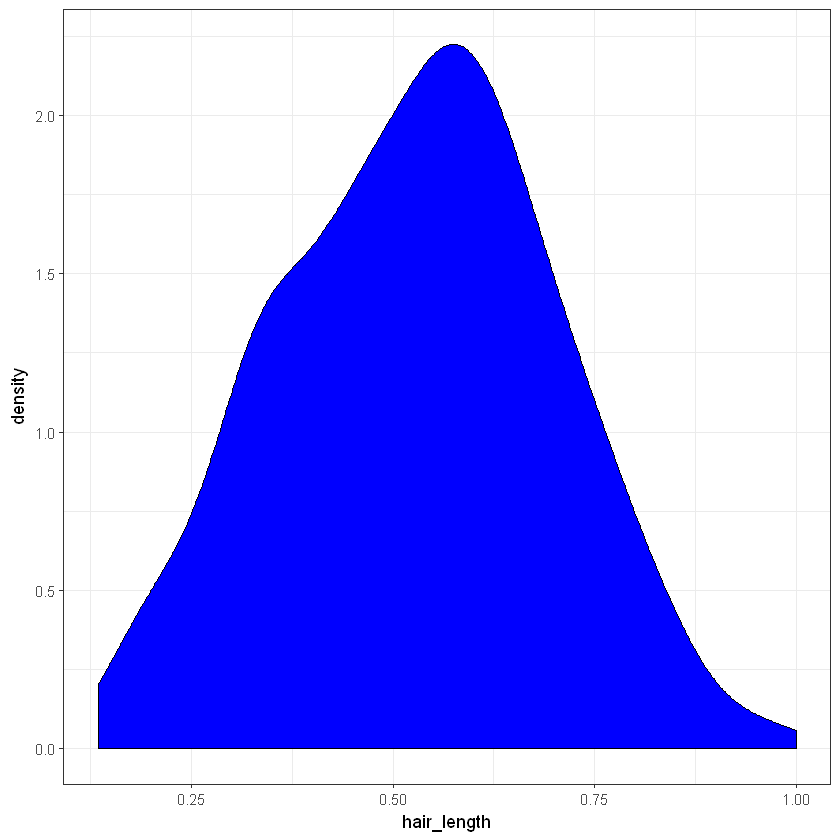

In [6]:
ggplot(monstres,aes(hair_length))+geom_density(fill="blue")+ theme_bw()

In [9]:
shapiro.test(monstres$hair_length)


	Shapiro-Wilk normality test

data:  monstres$hair_length
W = 0.99394, p-value = 0.1455


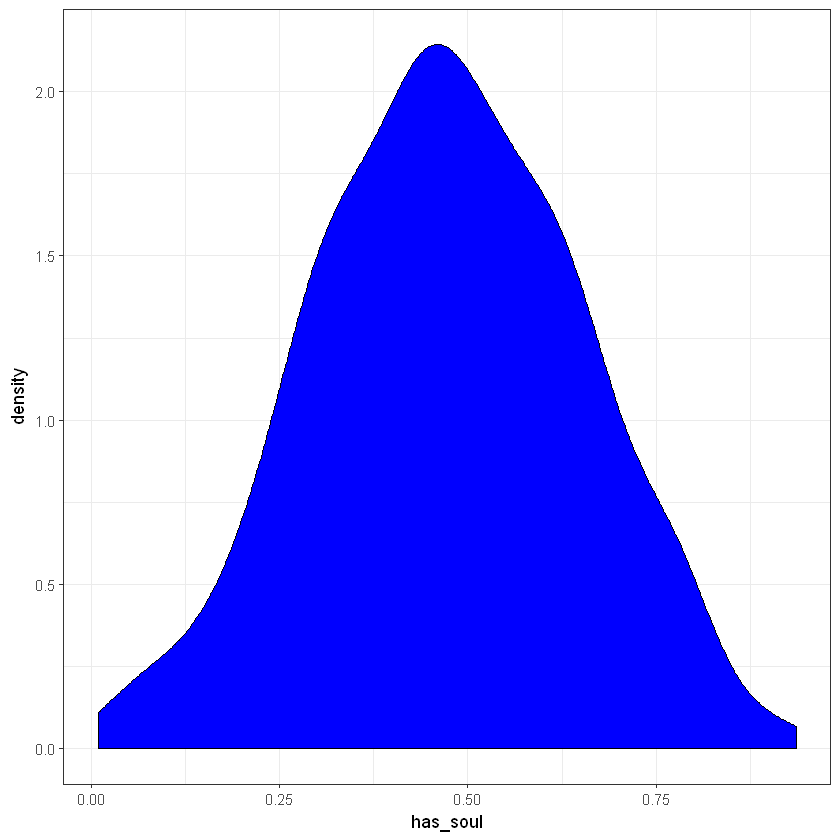

In [7]:
ggplot(monstres,aes(has_soul))+geom_density(fill="blue")+ theme_bw()

In [10]:
shapiro.test(monstres$hair_length)


	Shapiro-Wilk normality test

data:  monstres$hair_length
W = 0.99394, p-value = 0.1455


Ces graphiques viennent renforcir notre hypothèse selon laquelle ces variables sont distribuées selon des loi normales. De plus, les tests de normalité pour chacune des variables ne nous permet pas de rejeter l'hypothèse selon laquelle ces variables sont distribuées selon une loi normale. Le graphiques suivant montre la distribution des couleurs selon les étiquettes de nos observations.

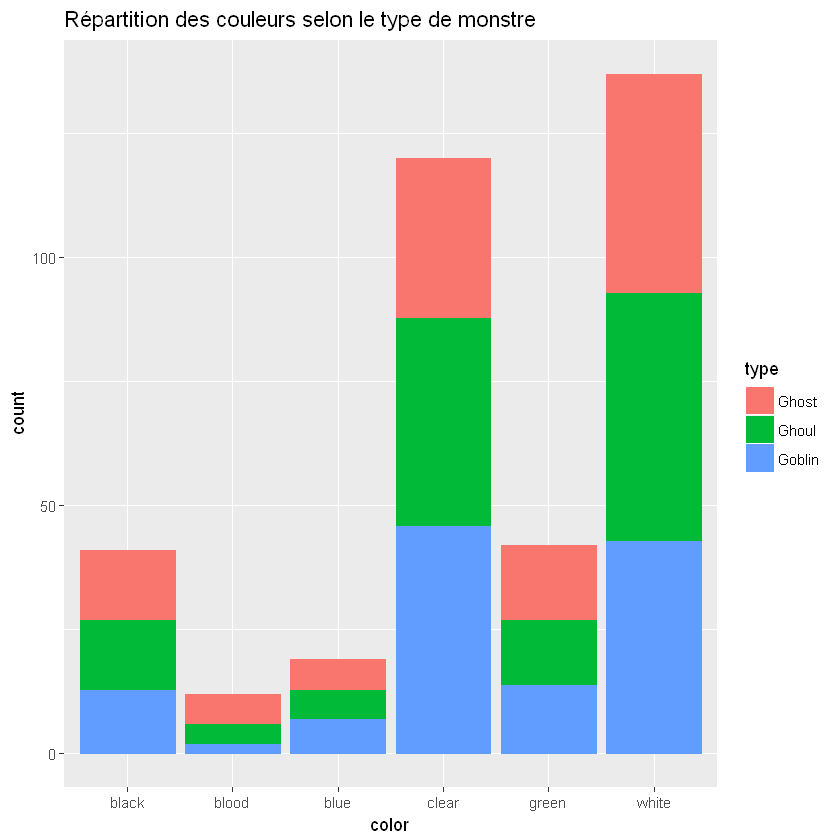

In [12]:
ggplot(monstres,aes(x = color,fill=type,color=type))+
  stat_count()+ggtitle("Répartition des couleurs selon le type de monstre")

Ce graphique montre clairement que dans chaque cathégorie de la variable "color", la proportion d'observations de chacun des trois type de monstre est sensiblement identique. Vérifions cette hypothèse en placant ces données dans un tableau et en calculant le pourcentage d'écart entre la moyenne et la fréquence de chacun des type d'observation.

In [13]:
proportion<-data.frame(table(monstres$color,monstres$type))
proportion<-dcast(proportion, Var1~Var2)

Using 'Freq' as value column. Use 'value.var' to override


In [15]:
transform(proportion, Moyenne=round(rowMeans(proportion[,2:4]),2), 
          Ecart.Ghost=round(1-(proportion[,2])/rowMeans(proportion[,2:4]),2)*100,
         Ecart.Ghoul=round(1-(proportion[,3])/rowMeans(proportion[,2:4]),2)*100,
          Ecart.Goblin=round(1-(proportion[,4])/rowMeans(proportion[,2:4]),2)*100)

,Var1,Ghost,Ghoul,Goblin,Moyenne,Ecart.Ghost,Ecart.Ghoul,Ecart.Goblin
1,black,14,14,13,13.67,-2,-2,5
2,blood,6,4,2,4,-50,0,50
3,blue,6,6,7,6.33,5,5,-11
4,clear,32,42,46,40,20,-5,-15
5,green,15,13,14,14,-7,7,0
6,white,44,50,43,45.67,4,-9,6


Nous voyons que pour la pluspart des couleurs, le pourcentage d'écart est sensiblement égale entre les trois catégories. Cela nous indique que cette variable ne permet pas de discerner entre chacune des trois catégorie et donc qu'elle n'aura pas beaucoup d'influence positive sur le modèle.

 Maintenant, mesurons la corrélation entre les variables continues du modèle pour vérifier si certaine d'entre elle devrait être omit du modèle. Nous allons dessiner une matrice de corrélation pour évaluer visuellement si il existe des liens entre ces quatres variables.

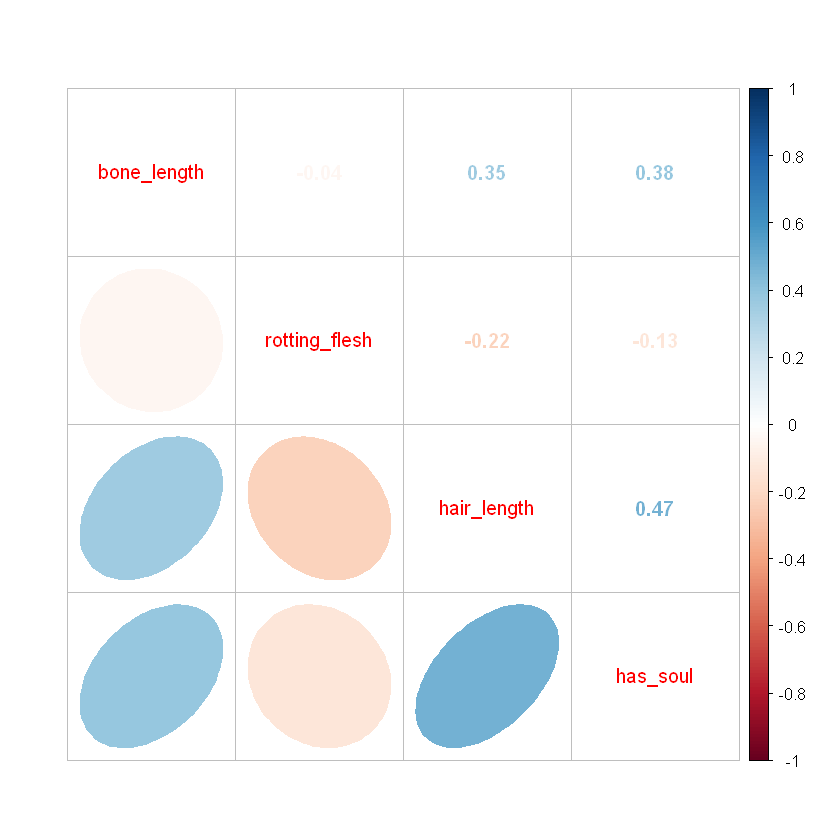

In [17]:
corrplot.mixed(cor(monstres[,2:5,with=F]), lower="ellipse", upper="number")

Cette matrice de corrélation montre qu'il existe une corrélation positive relativement forte entre les variables "hair_length" et "has_soul", ainsi que de faible corrélations positive entre les variables "bone_length/hair_length" et "bone_length/has_soul". Les nuages de points ci-dessous montre comment sont dispercé les types de montres selon chaque paires de variables.

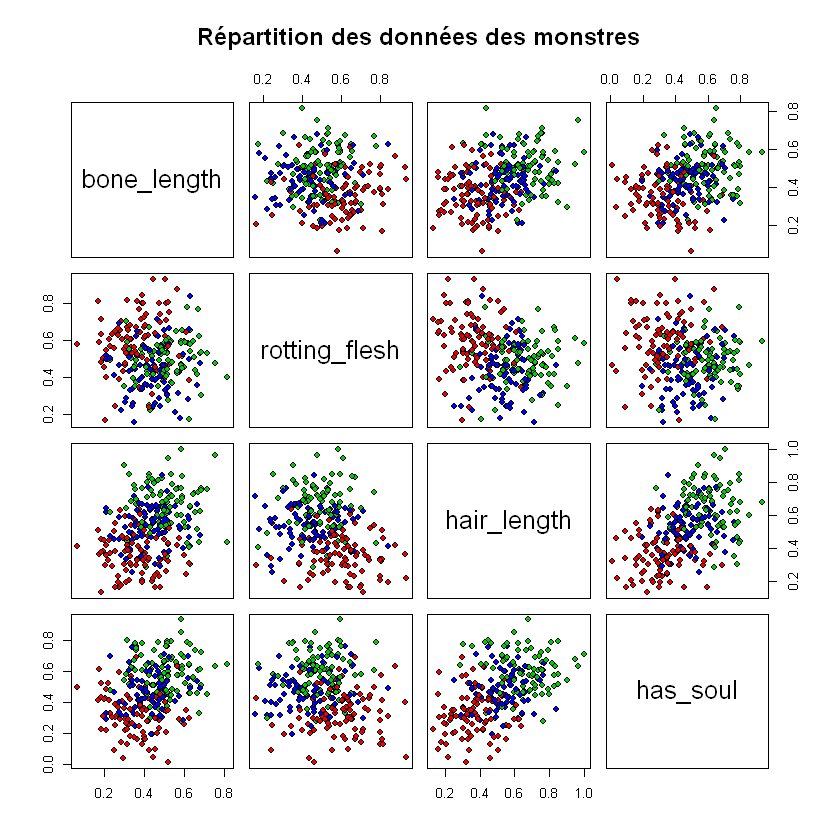

In [19]:
pairs(subset(train, select = c("bone_length","rotting_flesh","hair_length","has_soul")),
             main = "Répartition des données des monstres",
      pch = 21, bg = c("red2", "green3", "blue")[unclass(train$type)])

Ces nuages de points montrent qu'il n'existe pas de frontière claire entre les données de chacune des trois catégories d'observations. Puisque l'efficacité des algorithmes de partitions diminue considérablement lorsque les données ne sont pas séparable, on en conclue qu'il ne sera pas trivial d'obtenir un bon taux de classification en utilisant uniquement les variables précédentes.

# Nouvelles variables

Maintenant essayons de créer de nouvelles variables qui contriburons à améliorer notre modèle. Puisque nos données ne sont pas linéairement séparable, nous voulons créer des variables qui vont distancer les trois catégories. Regardons la distribution de la variable "has_soul" selon le type de monstre.

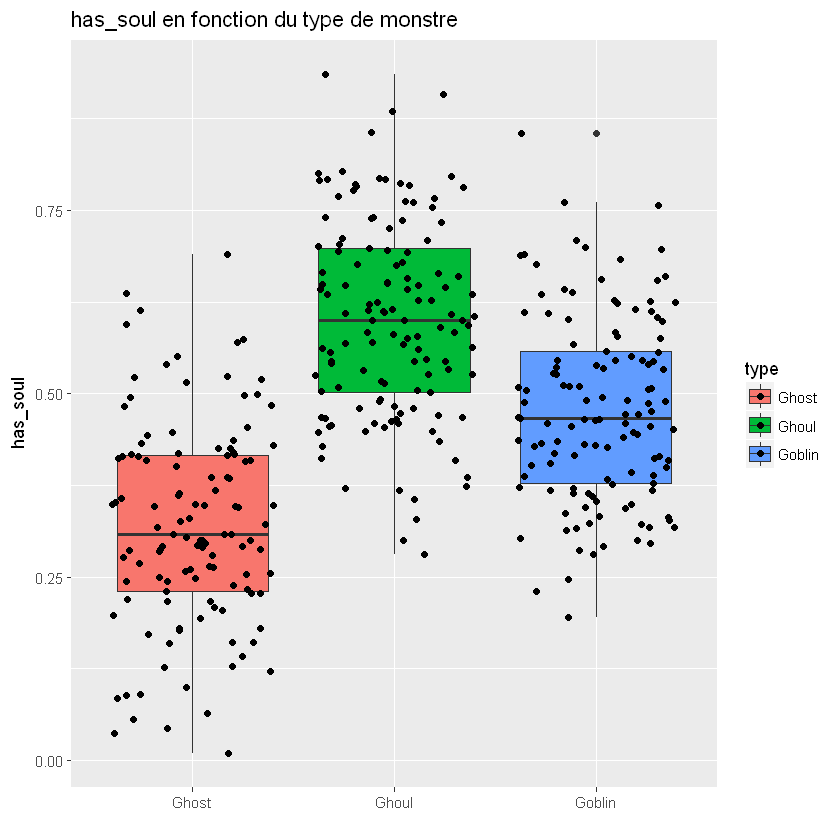

In [21]:
qplot(type,has_soul, data=monstres, geom=c("boxplot", "jitter"),
   fill=type, main="has_soul en fonction du type de monstre", xlab="", ylab="has_soul") 

In [22]:
mean(subset(monstres, type == "Ghost")$has_soul)
mean(subset(monstres, type == "Ghoul")$has_soul)
mean(subset(monstres, type == "Goblin")$has_soul)

[1] 0.3200232

[1] 0.6016345

[1] 0.4786631

Nous voyons que les moyennes des données provenant des catégories Ghost et Ghoul sont distinctes. En multipliant cette variable par elle-même, nous augmentons la distance entre les points de ces deux catégories. Pour ce faire, nous créeons la variable soul_square et l'ajoutons à notre data frame monstres

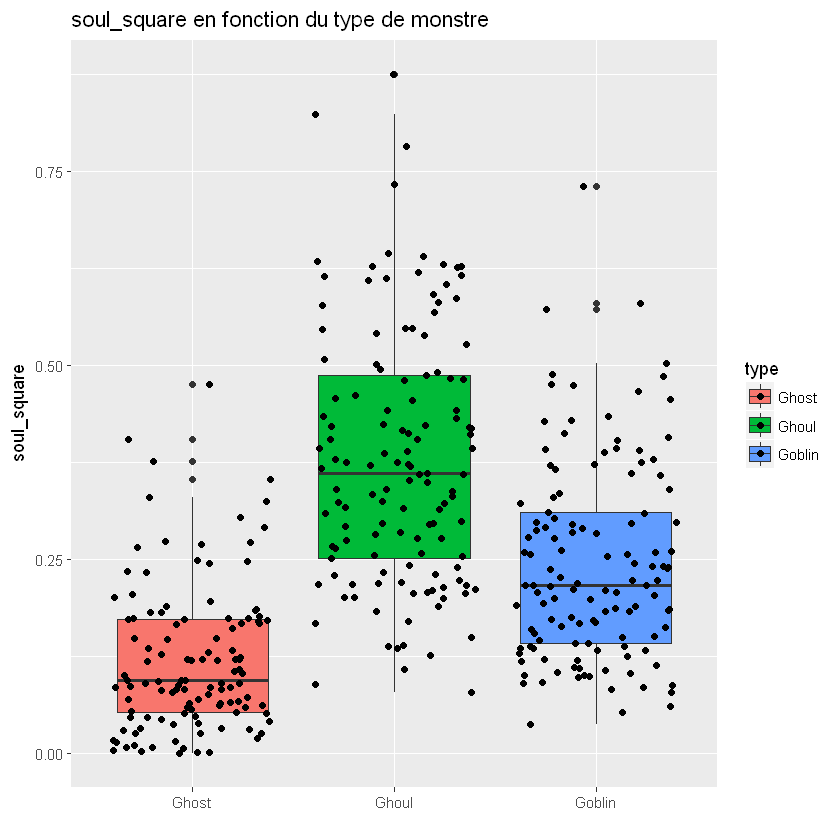

In [23]:
monstres$soul_square=monstres$has_soul*monstres$has_soul
qplot(type,soul_square, data=monstres, geom=c("boxplot", "jitter"),
   fill=type, main="soul_square en fonction du type de monstre", xlab="", ylab="soul_square")

In [24]:
mean(subset(monstres, type == "Ghost")$soul_square)
mean(subset(monstres, type == "Ghoul")$soul_square)
mean(subset(monstres, type == "Goblin")$soul_square)

[1] 0.1217889

[1] 0.3799978

[1] 0.2451922

Les résultats précédents montre que la multiplication de la variable has_soul déplace les trois distributions vers 0, mais que la moyenne du nuage de point de la variable Ghoul est maintenant trois fois plus grande que la moyenne du nuage de point de la variable Ghost. Cela en soit est un indicateur que cette variable pourra contribuer positivement au modèle. Malheureusement, l'opération à aussi étendu le nuage de point de la variable Goblin et cela va ajouter beaucoup de bruit dans les observations, ce qui pourra contrer les avantages de l'opérations.  

Regardons la distribution des autres variables pour voir si le même raisonnement peut s'appliquer à celles-ci.

[1] 0.3731864

[1] 0.6555501

[1] 0.544581

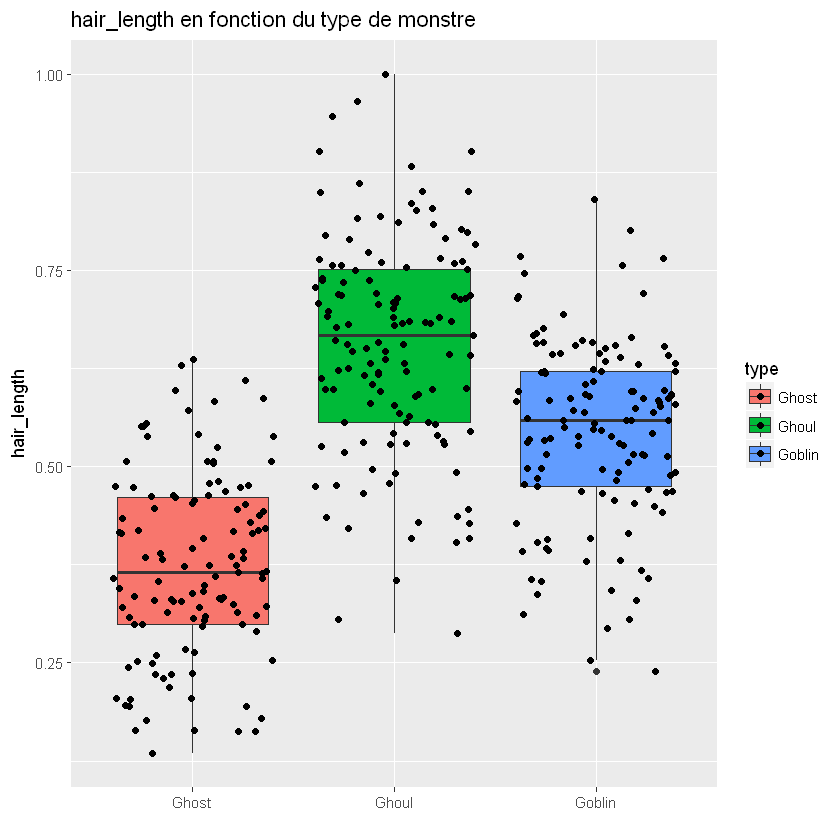

In [25]:
qplot(type,hair_length, data=monstres, geom=c("boxplot", "jitter"),
   fill=type, main="hair_length en fonction du type de monstre", xlab="", ylab="hair_length") 
mean(subset(monstres, type == "Ghost")$hair_length)
mean(subset(monstres, type == "Ghoul")$hair_length)
mean(subset(monstres, type == "Goblin")$hair_length)

[1] 0.347466

[1] 0.5171592

[1] 0.4296503

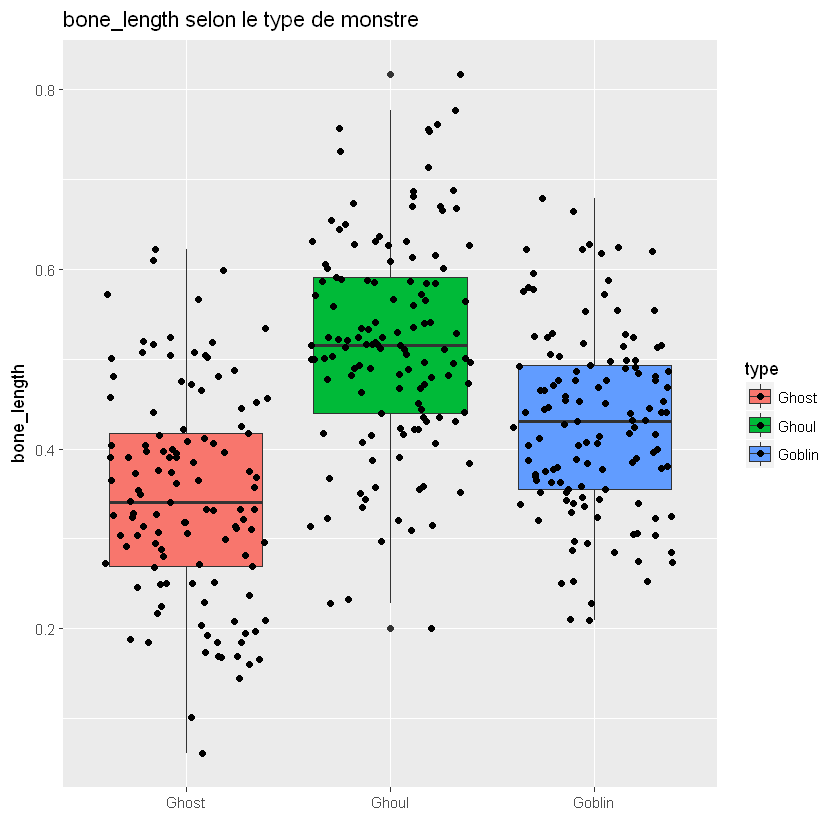

In [28]:
qplot(type,bone_length, data=monstres, geom=c("boxplot", "jitter"),
   fill=type, main="bone_length selon le type de monstre", xlab="", ylab="bone_length") 
mean(subset(monstres, type == "Ghost")$bone_length)
mean(subset(monstres, type == "Ghoul")$bone_length)
mean(subset(monstres, type == "Goblin")$bone_length)

[1] 0.5937587

[1] 0.4905146

[1] 0.4423571

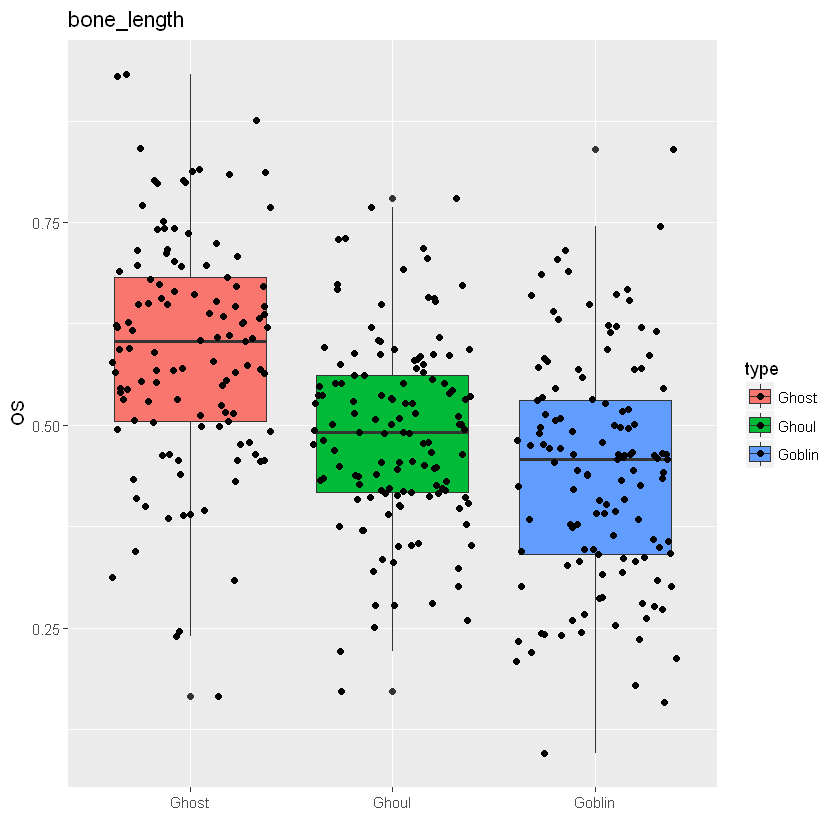

In [27]:
qplot(type,rotting_flesh, data=monstres, geom=c("boxplot", "jitter"),
   fill=type, main="bone_length", xlab="", ylab="OS") 
mean(subset(monstres, type == "Ghost")$rotting_flesh)
mean(subset(monstres, type == "Ghoul")$rotting_flesh)
mean(subset(monstres, type == "Goblin")$rotting_flesh)

Nous voyons que le même raisonnement peux s'appliquer aux variables "bone_length" et "hair_length", mais que pour la variable "rotting_flesh" la différences entre les moyennes des nuages de points n'est pas assez grande pour que la multiplication sépare les points des trois cathégories. De plus, ce dernier graphique nous indique que cette variable aura probablement peu d'influence positive sur le modèle.


In [29]:
monstres$hair_square=monstres$hair_length*monstres$hair_length
monstres$soul_square=monstres$has_soul*monstres$has_soul
monstres$bone_square=monstres$bone_length*monstres$bone_length

Nous pouvons étendre ce raisonnement aux paires de variables. En effet, les distributions des variables "hair_length" et "has_soul" ont sensiblement la même séparations entre les nuages de points des Ghost et des Goblins, donc multiplier ces deux variables nous permettra d'obtenir une nouvelle variable dont les données sont plus séparées.

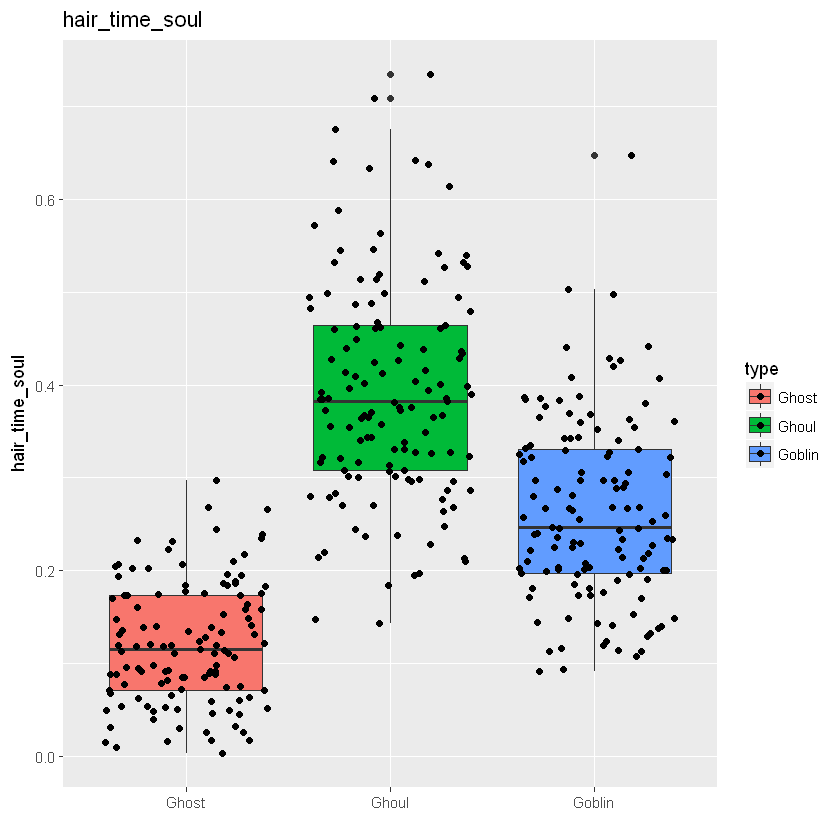

In [30]:
monstres$hair_time_soul=monstres$hair_length*monstres$has_soul
qplot(type,hair_time_soul, data=monstres, geom=c("boxplot", "jitter"),
   fill=type, main="hair_time_soul", xlab="", ylab="hair_time_soul") 

In [31]:
mean(subset(monstres, type == "Ghost")$hair_time_soul)
mean(subset(monstres, type == "Ghoul")$hair_time_soul)
mean(subset(monstres, type == "Goblin")$hair_time_soul)

[1] 0.1209636

[1] 0.3931636

[1] 0.2633721

La présence de corrélation entre les variables "hair_length", "has_soul" et "bone_length", ainsi que les nuages de points nous indique quelles sont de bonne candidates pour la création de nouvelles variables.

In [ ]:
monstres$hair_time_soul=monstres$hair_length*monstres$has_soul
monstres$hair_time_bone=monstres$hair_length*monstres$bone_length
monstres$bone_time_soul=monstres$bone_length*monstres$has_soul

In [ ]:
Après avoir ajouté ces nouvelles variables, notre tableau de donnée à la structure suivante:

In [32]:
str(monstres)

Classes 'data.table' and 'data.frame':	371 obs. of  11 variables:
 $ id            : int  0 1 2 4 5 7 8 11 12 19 ...
 $ bone_length   : num  0.355 0.576 0.468 0.777 0.566 ...
 $ rotting_flesh : num  0.351 0.426 0.354 0.509 0.876 ...
 $ hair_length   : num  0.466 0.531 0.812 0.637 0.419 ...
 $ has_soul      : num  0.781 0.44 0.791 0.884 0.636 ...
 $ color         : Factor w/ 6 levels "black","blood",..: 4 5 1 1 5 5 6 4 3 6 ...
 $ type          : Factor w/ 3 levels "Ghost","Ghoul",..: 2 3 2 2 1 3 3 2 1 1 ...
 $ soul_square   : num  0.61 0.194 0.626 0.782 0.405 ...
 $ hair_square   : num  0.217 0.282 0.659 0.405 0.175 ...
 $ bone_square   : num  0.126 0.331 0.219 0.603 0.32 ...
 $ hair_time_soul: num  0.364 0.234 0.642 0.563 0.266 ...
 - attr(*, ".internal.selfref")=<externalptr> 


Maintenant nous sommes prèt à batir notre modèle.